### Fundamentals of machine learning
After the three practical examples in chapter 4, you should be starting to feel familiar with how to approach classification and regression problems using neural networks, and you’ve witnessed the central problem of machine learning: overfitting.<br>
This chapter will formalize some of your new intuition about machine learning into a solid conceptual framework, highlighting the importance of accurate model evaluation and the balance between training and generalization.

#### Generalization: The goal of machine learning
In the three examples presented in chapter 4—predicting movie reviews, topic classification, and house-price regression—we split the data into a training set, a validation set, and a test set. The reason not to evaluate the models on the same data they were trained on quickly became evident: after just a few epochs, performance on never-before-seen data started diverging from performance on the training data, which always improves as training progresses. <br>
The models started to **overfit**. Overfitting happens in every machine learning problem. <br>
The fundamental issue in machine learning is the tension between optimization and generalization. **Optimization** refers to the process of adjusting a model to get the best performance possible on the training data (the learning in machine learning), whereas **generalization** refers to how well the trained model performs on data it has never seen before. The goal of the game is to get good generalization, of course, but you don’t control generalization; you can only fit the model to its training data. <br> 
If you do that too well, overfitting kicks in and generalization suffers. <br>
But what causes overfitting? How can we achieve good generalization?

##### Underfitting and overfitting
For the models you saw in the previous chapter, performance on the held-out validation data started improving as training went on and then inevitably peaked after a while. This pattern (illustrated in figure 5.1) is universal. You’ll see it with any model type and any dataset.

![overfitting](./images/5.1.png)

At the beginning of training, optimization and generalization are correlated: the lower the loss on training data, the lower the loss on test data. While this is happening, your model is said to be **underfit**: there is still progress to be made; the network hasn’t yet modeled all relevant patterns in the training data. But after a certain number of iterations on the training data, generalization stops improving, validation metrics stall and then begin to degrade: the model is starting to **overfit**. That is, it’s beginning to learn patterns that are specific to the training data but that are misleading or irrelevant when it comes to new data. <br>
Overfitting is particularly likely to occur when your data is noisy, if it involves uncertainty, or if it includes rare features. Let’s look at concrete examples.

##### NOISY TRAINING DATA
In real-world datasets, it’s fairly common for some inputs to be invalid. Perhaps a MNIST digit could be an all-black image, for instance, or something like figure 5.2.

![noisy-data](./images/5.2.png)

What are these? I don’t know either. But they’re all part of the MNIST training set.
What’s even worse, however, is having perfectly valid inputs that end up mislabeled, like those in figure 5.3.

![mislabeled-data](./images/5.3.png)

If a model goes out of its way to incorporate such outliers, its generalization performance will degrade, as shown in figure 5.4. For instance, a 4 that looks very close to the mislabeled 4 in figure 5.3 may end up getting classified as a 9.

![](./images/5.4.png)

##### AMBIGUOUS FEATURES
Not all data noise comes from inaccuracies—even perfectly clean and neatly labeled data can be noisy when the problem involves uncertainty and ambiguity. In classification tasks, it is often the case that some regions of the input feature space are associated with multiple classes at the same time. Let’s say you’re developing a model that takes an image of a banana and predicts whether the banana is unripe, ripe, or rotten. <br>
These categories have no objective boundaries, so the same picture might be classified as either unripe or ripe by different human labelers. Similarly, many problems involve randomness. You could use atmospheric pressure data to predict whether it will rain tomorrow, but the exact same measurements may be followed sometimes by rain and sometimes by a clear sky, with some probability. <br>
A model could overfit to such probabilistic data by being too confident about ambiguous regions of the feature space, like in figure 5.5. A more robust fit would ignore individual data points and look at the bigger picture.

![](./images/5.5.png)

##### RARE FEATURES AND SPURIOUS CORRELATIONS
If you’ve only ever seen two orange tabby cats in your life, and they both happened to be terribly antisocial, you might infer that orange tabby cats are generally likely to be antisocial. That’s overfitting: if you had been exposed to a wider variety of cats, including more orange ones, you’d have learned that cat color is not well correlated with character. <br>
Likewise, machine learning models trained on datasets that include rare feature values are highly susceptible to overfitting. In a sentiment classification task, if the word “cherimoya” (a fruit native to the Andes) only appears in one text in the training data, and this text happens to be negative in sentiment, a poorly regularized model might put a very high weight on this word and always classify new texts that mention cherimoyas as negative, whereas, objectively, there’s nothing negative about the cherimoya. <br>
Importantly, a feature value doesn’t need to occur only a couple of times to lead to spurious correlations. Consider a word that occurs in 100 samples in your training data and that’s associated with a positive sentiment 54% of the time and with a negative sentiment 46% of the time. That difference may well be a complete statistical fluke, yet your model is likely to learn to leverage that feature for its classification task. <br>
This is one of the most common sources of **overfitting**. <br>
Here’s a striking example. Take MNIST. Create a new training set by concatenating 784 white noise dimensions to the existing 784 dimensions of the data, so half of the data is now noise. For comparison, also create an equivalent dataset by concatenating 784 all-zeros dimensions. Our concatenation of meaningless features does not at all affect the information content of the data: we’re only adding something. **Human classification accuracy wouldn’t be affected by these transformations at all.**

##### Adding white noise channels or all-zeros channels to MNIST

In [2]:
from tensorflow.keras.datasets import mnist
import numpy as np

(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

train_images_with_noise_channels = np.concatenate(
    [train_images, np.random.random((len(train_images), 784))], axis=1)

train_images_with_zeros_channels = np.concatenate(
    [train_images, np.zeros((len(train_images), 784))], axis=1)

Now, let’s train the model from chapter 2 on both of these training sets.
##### Training the same model on MNIST data with noise channels or all-zero channels

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model():
    model = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model = get_model()
history_noise = model.fit(
    train_images_with_noise_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

model = get_model()
history_zeros = model.fit(
    train_images_with_zeros_channels, train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 5s 11ms/step - loss: 0.6323 - accuracy: 0.8067 - val_loss: 0.2572 - val_accuracy: 0.9219
Epoch 2/10
375/375 [==============================] - 4s 11ms/step - loss: 0.2492 - accuracy: 0.9223 - val_loss: 0.2133 - val_accuracy: 0.9363
Epoch 3/10
375/375 [==============================] - 4s 11ms/step - loss: 0.1592 - accuracy: 0.9508 - val_loss: 0.1411 - val_accuracy: 0.9576
Epoch 4/10
375/375 [==============================] - 4s 11ms/step - loss: 0.1107 - accuracy: 0.9652 - val_loss: 0.1804 - val_accuracy: 0.9448
Epoch 5/10
375/375 [==============================] - 4s 11ms/step - loss: 0.0844 - accuracy: 0.9730 - val_loss: 0.1359 - val_accuracy: 0.9618
Epoch 6/10
375/375 [==============================] - 4s 10ms/step - loss: 0.0609 - accuracy: 0.9800 - val_loss: 0.1359 - val_accuracy: 0.9631
Epoch 7/10
375/375 [==============================] - 4s 10ms/step - loss: 0.0437 - accuracy: 0.9857 - val_loss: 0.1402 - val_accuracy: 0.9639

Let’s compare how the validation accuracy of each model evolves over time.
##### Plotting a validation accuracy comparison

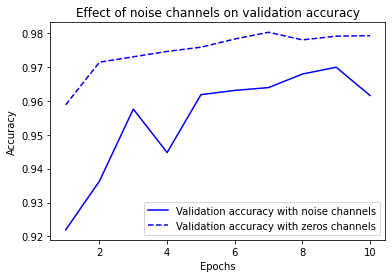

In [4]:
import matplotlib.pyplot as plt
val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]
epochs = range(1, 11)
plt.plot(epochs, val_acc_noise, "b-",
         label="Validation accuracy with noise channels")
plt.plot(epochs, val_acc_zeros, "b--",
         label="Validation accuracy with zeros channels")
plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

Despite the data holding the same information in both cases, the validation accuracy of the model trained with noise channels ends up about one percentage point lower—purely through the influence of spurious correlations. The more noise channels you add, the further accuracy will degrade. <br>
Noisy features inevitably lead to overfitting. As such, in cases where you aren’t sure whether the features you have are informative or distracting, it’s common to do **feature selection** before training. Restricting the IMDB data to the top 10,000 most common words was a crude form of feature selection, for instance. The typical way to do feature selection is to compute some usefulness score for each feature available—a measure of how informative the feature is with respect to the task, such as the mutual information between the feature and the labels—and only keep features that are above some threshold. Doing this would filter out the white noise channels in the preceding example.

#### The nature of generalization in deep learning
A remarkable fact about deep learning models is that they can be trained to fit anything, as long as they have enough representational power. <br>
Don’t believe me? Try shuffling the MNIST labels and train a model on that. Even though there is no relationship whatsoever between the inputs and the shuffled labels, the training loss goes down just fine, even with a relatively small model. Naturally, the validation loss does not improve at all over time, since there is no possibility of generalization in this setting.

##### Fitting an MNIST model with randomly shuffled labels

In [5]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

random_train_labels = train_labels[:]
np.random.shuffle(random_train_labels)

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, random_train_labels,
          epochs=100,
          batch_size=128,
          validation_split=0.2)

Epoch 1/100
375/375 [==============================] - 3s 7ms/step - loss: 2.3164 - accuracy: 0.1049 - val_loss: 2.3062 - val_accuracy: 0.1080
Epoch 2/100
375/375 [==============================] - 3s 7ms/step - loss: 2.2996 - accuracy: 0.1181 - val_loss: 2.3117 - val_accuracy: 0.1042
Epoch 3/100
375/375 [==============================] - 3s 7ms/step - loss: 2.2890 - accuracy: 0.1296 - val_loss: 2.3209 - val_accuracy: 0.1051
Epoch 4/100
375/375 [==============================] - 2s 7ms/step - loss: 2.2752 - accuracy: 0.1422 - val_loss: 2.3320 - val_accuracy: 0.1018
Epoch 5/100
375/375 [==============================] - 2s 7ms/step - loss: 2.2581 - accuracy: 0.1550 - val_loss: 2.3376 - val_accuracy: 0.1017
Epoch 6/100
375/375 [==============================] - 2s 6ms/step - loss: 2.2368 - accuracy: 0.1677 - val_loss: 2.3510 - val_accuracy: 0.1003
Epoch 7/100
375/375 [==============================] - 2s 6ms/step - loss: 2.2145 - accuracy: 0.1831 - val_loss: 2.3694 - val_accuracy: 0.1022

In fact, you don’t even need to do this with MNIST data—you could just generate white noise inputs and random labels. You could fit a model on that, too, as long as it has enough parameters. It would just end up memorizing specific inputs, much like a Python dictionary. <br>
If this is the case, then how come deep learning models generalize at all? Shouldn’t they just learn an ad hoc mapping between training inputs and targets, like a fancy dict? What expectation can we have that this mapping will work for new inputs? As it turns out, the nature of generalization in deep learning has rather little to do with deep learning models themselves, and much to do with the structure of information in the real world.

#### Evaluating machine learning models
You can only control what you can observe. Since your goal is to develop models that can successfully generalize to new data, it’s essential to be able to reliably measure the generalization power of your model. In this section, I’ll formally introduce the different ways you can evaluate machine learning models. You’ve already seen most of them in action in the previous chapter.

##### Training, validation, and test sets
- Evaluating a model always boils down to splitting the available data into three sets: **training, validation, and test**. 
- You train on the training data and evaluate your model on the validation data. 
- Once your model is ready for prime time, you test it one final time on the test data, which is meant to be as similar as possible to production data.
- Then you can deploy the model in production. <br>
You may ask, why not have two sets: a training set and a test set? You’d train on the training data and evaluate on the test data. Much simpler! <br>

The reason is that developing a model always involves tuning its configuration: for example, choosing the number of layers or the size of the layers (called the **hyperparameters** of the model, to distinguish them from the **parameters**, which are the network’s weights). You do this tuning by using as a feedback signal the performance of the model on the validation data. In essence, this tuning is a form of learning: a search for a good configuration in some parameter space. As a result, tuning the configuration of the model based on its performance on the validation set can quickly result in overfitting to the validation set, even though your model is never directly trained on it. <br>

Central to this phenomenon is the notion of **information leaks**. Every time you tune a hyperparameter of your model based on the model’s performance on the validation set, some information about the validation data leaks into the model. If you do this only once, for one parameter, then very few bits of information will leak, and your validation set will remain reliable for evaluating the model. But if you repeat this many times—running one experiment, evaluating on the validation set, and modifying your model as a result—then you’ll leak an increasingly significant amount of information about the validation set into the model.

At the end of the day, you’ll end up with a model that performs artificially well on the validation data, because that’s what you optimized it for. You care about performance on completely new data, not on the validation data, so you need to use a completely different, **never-before-seen dataset** to evaluate the model: **the test dataset**. <br>
Your model shouldn’t have had access to any information about the test set, even indirectly. If anything about the model has been tuned based on test set performance, then your measure of generalization will be flawed.

Splitting your data into training, validation, and test sets may seem straightforward, but there are a few advanced ways to do it that can come in handy when little data is available. Let’s review three classic evaluation recipes: simple holdout validation, K-fold validation, and iterated K-fold validation with shuffling. We’ll also talk about the use of common-sense baselines to check that your training is going somewhere.

##### SIMPLE HOLDOUT VALIDATION
Set apart some fraction of your data as your test set. Train on the remaining data, and evaluate on the test set. As you saw in the previous sections, in order to prevent information leaks, you shouldn’t tune your model based on the test set, and therefore you should also reserve a validation set. <br>
Schematically, holdout validation looks like figure 5.12.

![](./images/5.12.png)

##### Holdout validation (note that labels are omitted for simplicity)

```python
num_validation_samples = 10000
np.random.shuffle(data) # Shuffling the data is usually appropriate.
validation_data = data[:num_validation_samples] # Defines the validation set
training_data = data[num_validation_samples:] # Defines the training set
model = get_model()
model.fit(training_data, ...)
validation_score = model.evaluate(validation_data, ...)
# Trains a model on the training data, and evaluates it on the validation data
... # At this point you can tune your model, retrain it, evaluate it, tune it again.
model = get_model()
model.fit(np.concatenate([training_data,
validation_data]), ...)
test_score = model.evaluate(test_data, ...)
# Once you’ve tuned your hyperparameters, it’s common to train your final model from scratch on all non-test data available.
```

This is the simplest evaluation protocol, and it suffers from one flaw: if little data is available, then your validation and test sets may contain too few samples to be statistically representative of the data at hand. This is easy to recognize: if different random shuffling rounds of the data before splitting end up yielding very different measures of model performance, then you’re having this issue. **K-fold validation** and **iterated K-fold validation** are two ways to address this, as discussed next.

##### K-FOLD VALIDATION
With this approach, you split your data into K partitions of equal size. For each partition i, train a model on the remaining K - 1 partitions, and evaluate it on partition i. <br>
Your final score is then the averages of the K scores obtained. This method is helpful when the performance of your model shows significant variance based on your train-test split. Like holdout validation, this method doesn’t exempt you from using a distinct validation set for model calibration. <br>
Schematically, K-fold cross-validation looks like figure 5.13.

![](./images/5.13.png)

##### K-fold cross-validation (note that labels are omitted for simplicity)

```python
k = 3
num_validation_samples = len(data) // k
np.random.shuffle(data)
validation_scores = []
for fold in range(k):
    validation_data = data[num_validation_samples * fold:  # Selects the validation data partition
        num_validation_samples * (fold + 1)]
    training_data = np.concatenate(
        data[:num_validation_samples * fold],
        data[num_validation_samples * (fold + 1):])
    # Uses the remainder of the data as training data. Note that the + operator represents list concatenation, not summation.
    model = get_model() # Creates a brand-new instance of the model (untrained)
    model.fit(training_data, ...)
    validation_score = model.evaluate(validation_data, ...)
    validation_scores.append(validation_score)
validation_score = np.average(validation_scores) # Validation score: average of the validation scores of the k folds
model = get_model()
model.fit(data, ...) # Trains the final model on all nontest data available
test_score = model.evaluate(test_data, ...)
```

##### ITERATED K-FOLD VALIDATION WITH SHUFFLING
This one is for situations in which you have relatively little data available and you need to evaluate your model as precisely as possible. I’ve found it to be extremely helpful in Kaggle competitions. It consists of applying K-fold validation multiple times, shuffling the data every time before splitting it K ways. The final score is the average of the scores obtained at each run of K-fold validation. Note that you end up training and evaluating P * K models (where P is the number of iterations you use), which can be very expensive.

##### Things to keep in mind about model evaluation
Keep an eye out for the following when you’re choosing an evaluation protocol:
- **Data representativeness**—You want both your training set and test set to be representative of the data at hand. For instance, if you’re trying to classify images of digits, and you’re starting from an array of samples where the samples are ordered by their class, taking the first 80% of the array as your training set and the remaining 20% as your test set will result in your training set containing only classes 0–7, whereas your test set will contain only classes 8–9. This seems like a ridiculous mistake, but it’s surprisingly common. For this reason, you usually should **randomly shuffle your data before splitting it into training and test sets.**
- **The arrow of time**—If you’re trying to **predict the future given the past** (for example, tomorrow’s weather, stock movements, and so on), **you should not randomly shuffle your data before splitting it**, because doing so will create a temporal leak: your model will effectively be trained on data from the future. In such situations, you should **always make sure all data in your test set is posterior to the data in the training set.**
- **Redundancy in your data**—If some data points in your data **appear twice** (fairly common with real-world data), then shuffling the data and splitting it into a training set and a validation set will result in redundancy between the training and validation sets. In effect, you’ll be testing on part of your training data, which is the worst thing you can do! **Make sure your training set and validation set are disjoint.**

Having a reliable way to evaluate the performance of your model is how you’ll be able to monitor the tension at the heart of machine learning—between optimization and generalization, underfitting and overfitting.

#### Improving model fit
To achieve the perfect fit, you must first overfit. Since you don’t know in advance where the boundary lies, you must cross it to find it. Thus, your initial goal as you start working on a problem is to achieve a model that shows some generalization power and that is able to overfit. Once you have such a model, you’ll focus on refining generalization by fighting overfitting. <br>
There are three common problems you’ll encounter at this stage:
- Training doesn’t get started: your training loss doesn’t go down over time.
- Training gets started just fine, but your model doesn’t meaningfully generalize: you can’t beat the common-sense baseline you set.
- Training and validation loss both go down over time, and you can beat your baseline, but you don’t seem to be able to overfit, which indicates you’re still underfitting.

Let’s see how you can address these issues to achieve the first big milestone of a machine learning project: getting a model that has some generalization power (it can beat a trivial baseline) and that is able to overfit.

##### Tuning key gradient descent parameters
Sometimes training doesn’t get started, or it stalls too early. Your loss is stuck. This is always something you can overcome: remember that you can fit a model to random data. Even if nothing about your problem makes sense, you should still be able to train something—if only by memorizing the training data. <br>
When this happens, it’s always a problem with the configuration of the gradient descent process: your choice of optimizer, the distribution of initial values in the weights of your model, your learning rate, or your batch size. All these parameters are interdependent, and as such it is usually sufficient to tune the learning rate and the batch size while keeping the rest of the parameters constant. <br>
Let’s look at a concrete example: let’s train the MNIST model from chapter 2 with an inappropriately large learning rate of value 1.

##### Training an MNIST model with an incorrectly high learning rate

In [6]:
(train_images, train_labels), _ = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1.),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 3s 7ms/step - loss: 850.0276 - accuracy: 0.3504 - val_loss: 2.2311 - val_accuracy: 0.2449
Epoch 2/10
375/375 [==============================] - 2s 6ms/step - loss: 4.6690 - accuracy: 0.2246 - val_loss: 2.4064 - val_accuracy: 0.2244
Epoch 3/10
375/375 [==============================] - 2s 6ms/step - loss: 2.8338 - accuracy: 0.2365 - val_loss: 3.8123 - val_accuracy: 0.2853
Epoch 4/10
375/375 [==============================] - 2s 6ms/step - loss: 2.9162 - accuracy: 0.2397 - val_loss: 2.3583 - val_accuracy: 0.2748
Epoch 5/10
375/375 [==============================] - 2s 6ms/step - loss: 3.4884 - accuracy: 0.2605 - val_loss: 2.1565 - val_accuracy: 0.2674
Epoch 6/10
375/375 [==============================] - 2s 6ms/step - loss: 2.6663 - accuracy: 0.2474 - val_loss: 2.4233 - val_accuracy: 0.2835
Epoch 7/10
375/375 [==============================] - 2s 6ms/step - loss: 2.6693 - accuracy: 0.2406 - val_loss: 2.2915 - val_accuracy: 0.2049
Epoc

The model quickly reaches a training and validation accuracy in the 30%–40% range, but cannot get past that. Let’s try to lower the learning rate to a more reasonable value of 1e-2.
##### The same model with a more appropriate learning rate

In [7]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer=keras.optimizers.RMSprop(1e-2),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          batch_size=128,
          validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 3s 7ms/step - loss: 0.3776 - accuracy: 0.9130 - val_loss: 0.1412 - val_accuracy: 0.9627
Epoch 2/10
375/375 [==============================] - 3s 7ms/step - loss: 0.1413 - accuracy: 0.9640 - val_loss: 0.1630 - val_accuracy: 0.9630
Epoch 3/10
375/375 [==============================] - 3s 7ms/step - loss: 0.1162 - accuracy: 0.9730 - val_loss: 0.1516 - val_accuracy: 0.9727
Epoch 4/10
375/375 [==============================] - 3s 7ms/step - loss: 0.1003 - accuracy: 0.9779 - val_loss: 0.2197 - val_accuracy: 0.9687
Epoch 5/10
375/375 [==============================] - 3s 7ms/step - loss: 0.0869 - accuracy: 0.9820 - val_loss: 0.2183 - val_accuracy: 0.9703
Epoch 6/10
375/375 [==============================] - 3s 7ms/step - loss: 0.0757 - accuracy: 0.9850 - val_loss: 0.3012 - val_accuracy: 0.9607
Epoch 7/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0738 - accuracy: 0.9864 - val_loss: 0.2440 - val_accuracy: 0.9732
Epoch 

The model is now able to train.
If you find yourself in a similar situation, try
- **Lowering or increasing the learning rate.** A learning rate that is too high may lead to updates that vastly overshoot a proper fit, like in the preceding example, and a learning rate that is too low may make training so slow that it appears to stall.
- **Increasing the batch size.** A batch with more samples will lead to gradients that are more informative and less noisy (lower variance).

You will, eventually, find a configuration that gets training started.

##### Leveraging better architecture priors
You have a model that fits, but for some reason your validation metrics aren’t improving at all. They remain no better than what a random classifier would achieve: your model trains but doesn’t generalize. What’s going on? <br>
This is perhaps the worst machine learning situation you can find yourself in. It indicates that something is fundamentally wrong with your approach, and it may not be easy to tell what. Here are some tips.

First, it may be that the input data you’re using simply doesn’t contain sufficient information to predict your targets: the problem as formulated is not solvable. This is what happened earlier when we tried to fit an MNIST model where the labels were shuffled: the model would train just fine, but validation accuracy would stay stuck at 10%, because it was plainly impossible to generalize with such a dataset. <br>
It may also be that the kind of model you’re using is not suited for the problem at hand. For instance, in chapter 10, you’ll see an example of a timeseries prediction problem where a densely connected architecture isn’t able to beat a trivial baseline, whereas a more appropriate recurrent architecture does manage to generalize well. <br>
Using a model that makes the right assumptions about the problem is essential to achieve generalization: you should leverage the right architecture priors.

In the following chapters, you’ll learn about the best architectures to use for a variety of data modalities—images, text, timeseries, and so on. In general, you should always make sure to read up on architecture best practices for the kind of task you’re attacking—chances are you’re not the first person to attempt it.

##### Increasing model capacity
If you manage to get to a model that fits, where validation metrics are going down, and that seems to achieve at least some level of generalization power, congratulations: you’re almost there. Next, you need to get your model to start overfitting. <br>
Consider the following small model—a simple logistic regression—trained on MNIST pixels.

##### A simple logistic regression on MNIST

In [8]:
model = keras.Sequential([layers.Dense(10, activation="softmax")])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_small_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)

Epoch 1/20
375/375 [==============================] - 1s 2ms/step - loss: 0.6601 - accuracy: 0.8376 - val_loss: 0.3603 - val_accuracy: 0.9059
Epoch 2/20
375/375 [==============================] - 1s 1ms/step - loss: 0.3509 - accuracy: 0.9036 - val_loss: 0.3078 - val_accuracy: 0.9149
Epoch 3/20
375/375 [==============================] - 1s 2ms/step - loss: 0.3154 - accuracy: 0.9125 - val_loss: 0.2924 - val_accuracy: 0.9170
Epoch 4/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2993 - accuracy: 0.9168 - val_loss: 0.2812 - val_accuracy: 0.9219
Epoch 5/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2896 - accuracy: 0.9188 - val_loss: 0.2769 - val_accuracy: 0.9237
Epoch 6/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2828 - accuracy: 0.9208 - val_loss: 0.2720 - val_accuracy: 0.9238
Epoch 7/20
375/375 [==============================] - 1s 2ms/step - loss: 0.2779 - accuracy: 0.9221 - val_loss: 0.2710 - val_accuracy: 0.9252
Epoch 

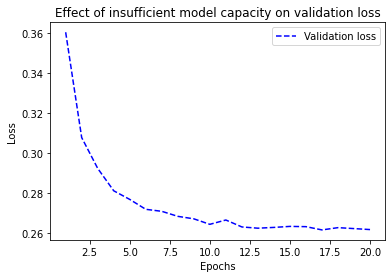

In [13]:
import matplotlib.pyplot as plt
val_loss = history_small_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--",
label="Validation loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Validation metrics seem to stall, or to improve very slowly, instead of peaking and reversing course. The validation loss goes to 0.26 and just stays there. You can fit, but you can’t clearly overfit, even after many iterations over the training data. You’re likely to encounter similar curves often in your career. <br>
Remember that it should always be possible to overfit. Much like the problem where the training loss doesn’t go down, this is an issue that can always be solved. **If you can’t seem to be able to overfit**, it’s likely a problem with the representational power of your model: **you’re going to need a bigger model**, one with more capacity, that is to say, one able to store more information. You can increase representational power by adding more layers, using bigger layers (layers with more parameters), or using kinds of layers that are more appropriate for the problem at hand (better architecture priors).

Let’s try training a bigger model, one with two intermediate layers with 96 units each:

In [14]:
model = keras.Sequential([
    layers.Dense(96, activation="relu"),
    layers.Dense(96, activation="relu"),
    layers.Dense(10, activation="softmax"),
])
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
history_large_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=128,
    validation_split=0.2)

Epoch 1/20
375/375 [==============================] - 2s 3ms/step - loss: 0.3526 - accuracy: 0.9007 - val_loss: 0.1913 - val_accuracy: 0.9439
Epoch 2/20
375/375 [==============================] - 1s 2ms/step - loss: 0.1589 - accuracy: 0.9528 - val_loss: 0.1341 - val_accuracy: 0.9607
Epoch 3/20
375/375 [==============================] - 1s 2ms/step - loss: 0.1127 - accuracy: 0.9666 - val_loss: 0.1159 - val_accuracy: 0.9659
Epoch 4/20
375/375 [==============================] - 1s 2ms/step - loss: 0.0865 - accuracy: 0.9736 - val_loss: 0.1022 - val_accuracy: 0.9697
Epoch 5/20
375/375 [==============================] - 1s 2ms/step - loss: 0.0694 - accuracy: 0.9786 - val_loss: 0.1012 - val_accuracy: 0.9697
Epoch 6/20
375/375 [==============================] - 1s 2ms/step - loss: 0.0567 - accuracy: 0.9833 - val_loss: 0.0963 - val_accuracy: 0.9730
Epoch 7/20
375/375 [==============================] - 1s 3ms/step - loss: 0.0479 - accuracy: 0.9859 - val_loss: 0.0998 - val_accuracy: 0.9718
Epoch 

The validation curve now looks exactly like it should: the model fits fast and starts overfitting after 8 epochs.

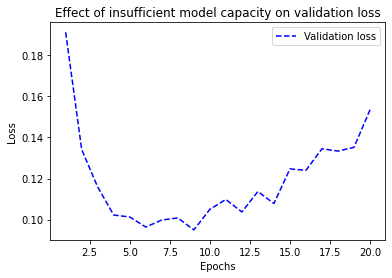

In [15]:
import matplotlib.pyplot as plt
val_loss = history_large_model.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--",
         label="Validation loss")
plt.title("Effect of insufficient model capacity on validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

#### Improving generalization
Once your model has shown itself to have some generalization power and to be able to overfit, it’s time to switch your focus to maximizing generalization.

##### Dataset curation
You’ve already learned that generalization in deep learning originates from the latent structure of your data. If your data makes it possible to smoothly interpolate between samples, you will be able to train a deep learning model that generalizes. If your problem is overly noisy or fundamentally discrete, like, say, list sorting, deep learning will not help you. Deep learning is curve fitting, not magic. <br>
As such, it is essential that you make sure that you’re working with an appropriate dataset. Spending more effort and money on data collection almost always yields a much greater return on investment than spending the same on developing a better model.
- Make sure you have enough data. Remember that you need a **dense sampling** of the input-cross-output space. **More data will yield a better model.** Sometimes, problems that seem impossible at first become solvable with a larger dataset.
- Minimize labeling errors—visualize your inputs to check for anomalies, and proofread your labels.
- Clean your data and deal with missing values (we’ll cover this in the next chapter).
- If you have many features and you aren’t sure which ones are actually useful, do feature selection.

A particularly important way to improve the generalization potential of your data is **feature engineering**. For most machine learning problems, feature engineering is a key ingredient for success. Let’s take a look.

##### Feature engineering
**Feature engineering** is the process of using your own knowledge about the data and about the machine learning algorithm at hand (in this case, a neural network) to make the algorithm work better by applying hardcoded (non-learned) transformations to the data before it goes into the model. In many cases, it isn’t reasonable to expect a machine learning model to be able to learn from completely arbitrary data. The data needs to be presented to the model in a way that will make the model’s job easier.

Let’s look at an intuitive example. Suppose you’re trying to develop a model that can take as input an image of a clock and can output the time of day (see figure 5.16).

![](./images/5.16.png)

If you choose to use the raw pixels of the image as input data, you have a difficult machine learning problem on your hands. You’ll need a convolutional neural network to solve it, and you’ll have to expend quite a bit of computational resources to train the network. <br>
But if you already understand the problem at a high level (you understand how humans read time on a clock face), you can come up with much better input features for a machine learning algorithm: for instance, it’s easy to write a five-line Python script to follow the black pixels of the clock hands and output the (x, y) coordinates of the tip of each hand. Then a simple machine learning algorithm can learn to associate these coordinates with the appropriate time of day. <br>
You can go even further: do a coordinate change, and express the (x, y) coordinates as polar coordinates with regard to the center of the image. Your input will become the angle **theta** of each clock hand. At this point, your features are making the problem so easy that no machine learning is required; a simple rounding operation and dictionary lookup are enough to recover the approximate time of day.

That’s the essence of feature engineering: making a problem easier by expressing it in a simpler way. Make the latent manifold smoother, simpler, better organized. Doing so usually requires understanding the problem in depth.

Before deep learning, feature engineering used to be the most important part of the machine learning workflow, because classical shallow algorithms didn’t have hypothesis spaces rich enough to learn useful features by themselves. The way you presented the data to the algorithm was absolutely critical to its success. For instance, before convolutional neural networks became successful on the MNIST digit-classification problem, solutions were typically based on hardcoded features such as the number of loops in a digit image, the height of each digit in an image, a histogram of pixel values, and so on. <br>
Fortunately, modern deep learning removes the need for most feature engineering, because neural networks are capable of automatically extracting useful features from raw data. Does this mean you don’t have to worry about feature engineering as long as you’re using deep neural networks? No, for two reasons:
- Good features still allow you to solve problems more elegantly while using fewer resources. For instance, it would be ridiculous to solve the problem of reading a clock face using a convolutional neural network.
- Good features let you solve a problem with far less data. The ability of deep learning models to learn features on their own relies on having lots of training data available; if you have only a few samples, the information value in their features becomes critical.

##### Using early stopping
In deep learning, we always use models that are vastly overparameterized: they have way more degrees of freedom than the minimum necessary to fit to the latent manifold of the data. This overparameterization is not an issue, because you never fully fit a deep learning model. Such a fit wouldn’t generalize at all. You will always interrupt training long before you’ve reached the minimum possible training loss. <br>
Finding the exact point during training where you’ve reached the most generalizable fit—the exact boundary between an underfit curve and an overfit curve—is one of the most effective things you can do to improve generalization. <br>
In the examples in the previous chapter, we would start by training our models for longer than needed to figure out the number of epochs that yielded the best validation metrics, and then we would retrain a new model for exactly that number of epochs. This is pretty standard, but it requires you to do redundant work, which can sometimes be expensive. Naturally, you could just save your model at the end of each epoch, and once you’ve found the best epoch, reuse the closest saved model you have.

In Keras, it’s typical to do this with an **EarlyStopping** callback, which will interrupt training as soon as validation metrics have stopped improving, while remembering the best known model state. You’ll learn to use callbacks in chapter 7.

##### Regularizing your model
Regularization techniques are a set of best practices that actively impede the model’s ability to fit perfectly to the training data, with the goal of making the model perform better during validation. This is called “regularizing” the model, because it tends to make the model simpler, more “regular,” its curve smoother, more “generic”; thus it is less specific to the training set and better able to generalize by more closely approximating the latent manifold of the data. <br>
Keep in mind that regularizing a model is a process that should always be guided by an accurate evaluation procedure. You will only achieve generalization if you can
measure it. <br>
Let’s review some of the most common regularization techniques and apply them in practice to improve the movie-classification model from chapter 4.

##### REDUCING THE NETWORK’S SIZE
You’ve already learned that a model that is too small will not overfit. The simplest way to mitigate overfitting is to **reduce the size of the model (the number of learnable parameters in the model, determined by the number of layers and the number of units per layer)**. If the model has limited memorization resources, it won’t be able to simply memorize its training data; thus, in order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets—precisely the type of representations we’re interested in. **At the same time, keep in mind that you should use models that have enough parameters that they don’t underfit: your model shouldn’t be starved for memorization resources.** There is a compromise to be found between too much capacity and not enough capacity. <br>
Unfortunately, there is no magical formula to determine the right number of layers or the right size for each layer. You must evaluate an array of different architectures (on your validation set, not on your test set, of course) in order to find the correct model size for your data. **The general workflow for finding an appropriate model size is to start with relatively few layers and parameters, and increase the size of the layers or add new layers until you see diminishing returns with regard to validation loss.**

Let’s try this on the movie-review classification model. The following listing shows our original model.

##### Original model

In [16]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), _ = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
train_data = vectorize_sequences(train_data)

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_original = model.fit(train_data, train_labels,
                             epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 33ms/step - loss: 0.5184 - accuracy: 0.7773 - val_loss: 0.3863 - val_accuracy: 0.8678
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.3069 - accuracy: 0.9019 - val_loss: 0.3443 - val_accuracy: 0.8594
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2232 - accuracy: 0.9280 - val_loss: 0.2865 - val_accuracy: 0.8872
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1760 - accuracy: 0.9431 - val_loss: 0.2768 - val_accuracy: 0.8906
Epoch 5/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1429 - accuracy: 0.9538 - val_loss: 0.2855 - val_accuracy: 0.8876
Epoch 6/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1180 - accuracy: 0.9631 - val_loss: 0.3009 - val_accuracy: 0.8847
Epoch 7/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0987 - accuracy: 0.9703 - val_loss: 0.3201 - val_accuracy: 0.8838
Epoch 8/20
30

Now let’s try to replace it with this smaller model.
##### Version of the model with lower capacity

In [17]:
model = keras.Sequential([
    layers.Dense(4, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_smaller_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 1s 27ms/step - loss: 0.6504 - accuracy: 0.6224 - val_loss: 0.6103 - val_accuracy: 0.7478
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.5789 - accuracy: 0.7457 - val_loss: 0.5608 - val_accuracy: 0.7669
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.5299 - accuracy: 0.8067 - val_loss: 0.5265 - val_accuracy: 0.8365
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.4924 - accuracy: 0.8478 - val_loss: 0.4996 - val_accuracy: 0.8282
Epoch 5/20
30/30 [==============================] - 0s 14ms/step - loss: 0.4614 - accuracy: 0.8754 - val_loss: 0.4807 - val_accuracy: 0.8373
Epoch 6/20
30/30 [==============================] - 0s 13ms/step - loss: 0.4347 - accuracy: 0.8990 - val_loss: 0.4715 - val_accuracy: 0.8286
Epoch 7/20
30/30 [==============================] - 0s 13ms/step - loss: 0.4119 - accuracy: 0.9136 - val_loss: 0.4601 - val_accuracy: 0.8402
Epoch 8/20
30

The smaller model starts overfitting later than the reference model, and its performance degrades more slowly once it starts overfitting.

Now, let’s add to our benchmark a model that has much more capacity—far more than the problem warrants. While it is standard to work with models that are significantly overparameterized for what they’re trying to learn, there can definitely be such a thing as too much memorization capacity. You’ll know your model is too large if it starts overfitting right away and if its validation loss curve looks choppy with highvariance (although choppy validation metrics could also be a symptom of using an unreliable validation process, such as a validation split that’s too small).

##### Version of the model with higher capacity

In [19]:
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_larger_model = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 4s 105ms/step - loss: 0.5551 - accuracy: 0.7467 - val_loss: 0.3028 - val_accuracy: 0.8856
Epoch 2/20
30/30 [==============================] - 3s 85ms/step - loss: 0.2565 - accuracy: 0.8992 - val_loss: 0.4158 - val_accuracy: 0.8269
Epoch 3/20
30/30 [==============================] - 3s 98ms/step - loss: 0.1596 - accuracy: 0.9399 - val_loss: 0.2986 - val_accuracy: 0.8921
Epoch 4/20
30/30 [==============================] - 3s 97ms/step - loss: 0.0736 - accuracy: 0.9741 - val_loss: 0.5105 - val_accuracy: 0.8515
Epoch 5/20
30/30 [==============================] - 3s 94ms/step - loss: 0.1118 - accuracy: 0.9761 - val_loss: 0.3396 - val_accuracy: 0.8854
Epoch 6/20
30/30 [==============================] - 3s 92ms/step - loss: 0.0061 - accuracy: 0.9994 - val_loss: 0.4922 - val_accuracy: 0.8854
Epoch 7/20
30/30 [==============================] - 3s 93ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.6020 - val_accuracy: 0.8852
Epoch 8/20
3

The bigger model starts overfitting almost immediately, after just one epoch, and it overfits much more severely. Its validation loss is also noisier. It gets training loss near zero very quickly. The more capacity the model has, the more quickly it can model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large difference between the training and validation loss).

##### ADDING WEIGHT REGULARIZATION
You may be familiar with the principle of Occam’s razor: given two explanations for something, the explanation most likely to be correct is the simplest one—the one that makes fewer assumptions. This idea also applies to the models learned by neural networks: given some training data and a network architecture, multiple sets of weight values (multiple models) could explain the data. Simpler models are less likely to overfit than complex ones. <br>
A simple model in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters, as you saw in the previous section). <br>
Thus, a common way to mitigate overfitting is to put constraints on the complexity of a model by forcing its weights to take only small values, which makes the distribution of weight values more regular. This is called **weight regularization**, and it’s done by adding to the loss function of the model a cost associated with having large weights. This cost comes in two flavors:
- **L1 regularization**—The cost added is proportional to the absolute value of the weight coefficients (the L1 norm of the weights).
- **L2 regularization**—The cost added is proportional to the square of the value of the weight coefficients (the L2 norm of the weights). L2 regularization is also called **weight decay** in the context of neural networks. Don’t let the different name confuse you: weight decay is mathematically the same as L2 regularization.

In Keras, weight regularization is added by passing **weight regularizer** instances to layers as keyword arguments. Let’s add L2 weight regularization to our initial movie-review classification model.

##### Adding L2 weight regularization to the model

In [20]:
from tensorflow.keras import regularizers
model = keras.Sequential([
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(16,
                 kernel_regularizer=regularizers.l2(0.002),
                 activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_l2_reg = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 29ms/step - loss: 0.5795 - accuracy: 0.7941 - val_loss: 0.4836 - val_accuracy: 0.8350
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.3936 - accuracy: 0.8937 - val_loss: 0.3894 - val_accuracy: 0.8840
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.3331 - accuracy: 0.9115 - val_loss: 0.3656 - val_accuracy: 0.8872
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.3016 - accuracy: 0.9243 - val_loss: 0.3602 - val_accuracy: 0.8867
Epoch 5/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2820 - accuracy: 0.9320 - val_loss: 0.3619 - val_accuracy: 0.8874
Epoch 6/20
30/30 [==============================] - 0s 15ms/step - loss: 0.2716 - accuracy: 0.9350 - val_loss: 0.3631 - val_accuracy: 0.8842
Epoch 7/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2607 - accuracy: 0.9381 - val_loss: 0.3632 - val_accuracy: 0.8845
Epoch 8/20
30

In the preceding listing, l2(0.002) means every coefficient in the weight matrix of
the layer will add 0.002 * weight_coefficient_value ** 2 to the total loss of the
model. Note that because this penalty is only added at training time, the loss for this
model will be much higher at training than at test time.
The plot below shows the impact of the L2 regularization penalty. As you can see, the model with L2 regularization has become much more resistant to overfitting than the reference model, even though both models have the same number of parameters.

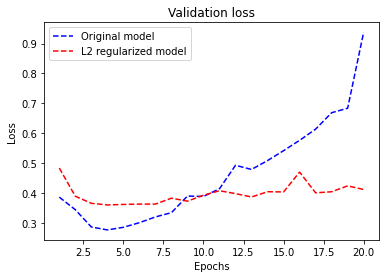

In [21]:
# Plot the validation loss of original model and l2 regularized model
import matplotlib.pyplot as plt
val_loss = history_original.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--", label="Original model")
val_loss_l2 = history_l2_reg.history["val_loss"]
plt.plot(epochs, val_loss_l2, "r--", label="L2 regularized model")
plt.title("Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

As an alternative to L2 regularization, you can use one of the following Keras weight regularizers.
##### Different weight regularizers available in Keras

In [22]:
from tensorflow.keras import regularizers
regularizers.l1(0.001) # L1 regularization
regularizers.l1_l2(l1=0.001, l2=0.001) # Simultaneous L1 and L2 regularization

Note that **weight regularization is more typically used for smaller deep learning models**. Large deep learning models tend to be so overparameterized that imposing constraints on weight values hasn’t much impact on model capacity and generalization. <br>
In these cases, a different regularization technique is preferred: **dropout**.

##### ADDING DROPOUT
**Dropout** is one of the most effective and most commonly used regularization techniques for neural networks; it was developed by Geoff Hinton and his students at the University of Toronto. Dropout, applied to a layer, consists of randomly dropping out (setting to zero) a number of output features of the layer during training. Let’s say a given layer would normally return a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training. After applying dropout, this vector will have a few zero entries distributed at random: for example, [0, 0.5, 1.3, 0, 1.1]. The dropout rate is the fraction of the features that are zeroed out; it’s usually set between 0.2 and 0.5. <br>
At test time, no units are dropped out; instead, **the layer’s output values are scaled down by a factor equal to the dropout rate**, to balance for the fact that more units are active than at training time.

Consider a NumPy matrix containing the output of a layer, layer_output, of shape (batch_size, features). At training time, we zero out at random a fraction of the values in the matrix:

```python
layer_output *= np.random.randint(0, high=2, size=layer_output.shape) 
# At training time, drops out 50% of the units in the output
```

At test time, we scale down the output by the dropout rate. Here, we scale by 0.5 (because we previously dropped half the units):

```python
layer_output *= 0.5 # At test time
```

Note that this process can be implemented by doing both operations at training time and leaving the output unchanged at test time, which is often the way it’s implemented in practice (see figure 5.20):

```python
layer_output *= np.random.randint(0, high=2, size=layer_output.shape) # At training time
layer_output /= 0.5 # Note that we’re scaling up rather than scaling down in this case.
```

![](./images/5.20.png)

This technique may seem strange and arbitrary. Why would this help reduce overfitting? Hinton says he was inspired by, among other things, a fraud-prevention mechanism used by banks. In his own words, “I went to my bank. The tellers kept changing and I asked one of them why. He said he didn’t know but they got moved around a lot. <br>
I figured it must be because it would require cooperation between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each example would prevent conspiracies and thus reduce overfitting.” The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that aren’t significant (what Hinton refers to as conspiracies), which the model will start memorizing if no noise is present.

In Keras, you can introduce dropout in a model via the **Dropout layer**, which is applied to the output of the layer right before it. Let’s add two Dropout layers in the IMDB model to see how well they do at reducing overfitting.

##### Adding dropout to the IMDB model

In [23]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history_dropout = model.fit(
    train_data, train_labels,
    epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 [==============================] - 2s 28ms/step - loss: 0.6350 - accuracy: 0.6377 - val_loss: 0.5485 - val_accuracy: 0.8296
Epoch 2/20
30/30 [==============================] - 0s 15ms/step - loss: 0.5208 - accuracy: 0.7698 - val_loss: 0.4306 - val_accuracy: 0.8655
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.4383 - accuracy: 0.8303 - val_loss: 0.3747 - val_accuracy: 0.8700
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.3789 - accuracy: 0.8629 - val_loss: 0.3236 - val_accuracy: 0.8809
Epoch 5/20
30/30 [==============================] - 0s 14ms/step - loss: 0.3282 - accuracy: 0.8933 - val_loss: 0.2861 - val_accuracy: 0.8927
Epoch 6/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2821 - accuracy: 0.9116 - val_loss: 0.2757 - val_accuracy: 0.8923
Epoch 7/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2534 - accuracy: 0.9238 - val_loss: 0.2914 - val_accuracy: 0.8881
Epoch 8/20
30

The plot below shows the results. This is a clear improvement over the reference model—it also seems to be working much better than L2 regularization, since the lowest validation loss reached has improved.

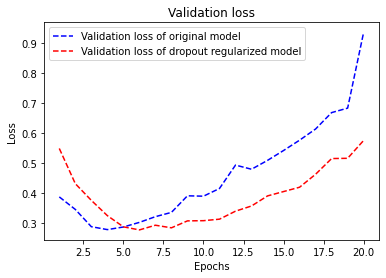

In [24]:
# Plot the validation loss of original model and l2 regularized model
import matplotlib.pyplot as plt
val_loss = history_original.history["val_loss"]
epochs = range(1, 21)
plt.plot(epochs, val_loss, "b--", label="Validation loss of original model")
val_loss_l2 = history_dropout.history["val_loss"]
plt.plot(epochs, val_loss_l2, "r--", label="Validation loss of dropout regularized model")
plt.title("Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

To recap, these are the most common ways to maximize generalization and prevent overfitting in neural networks:
- Get more training data, or better training data.
- Develop better features.
- Reduce the capacity of the model.
- Add weight regularization (for smaller models).
- Add dropout.

#### Summary
- The purpose of a machine learning model is to generalize: to perform accurately on never-before-seen inputs. It’s harder than it seems.
- A deep neural network achieves generalization by learning a parametric model that can successfully interpolate between training samples—such a model can be said to have learned the “latent manifold” of the training data. This is why deep learning models can only make sense of inputs that are very close to what they’ve seen during training.
- The fundamental problem in machine learning is the tension between optimization and generalization: to attain generalization, you must first achieve a good fit to the training data, but improving your model’s fit to the training data will inevitably start hurting generalization after a while. Every single deep learning best practice deals with managing this tension.
- The ability of deep learning models to generalize comes from the fact that they manage to learn to approximate the latent manifold of their data, and can thus make sense of new inputs via interpolation.
- It’s essential to be able to accurately evaluate the generalization power of your model while you’re developing it. You have at your disposal an array of evaluation methods, from simple holdout validation to K-fold cross-validation and iterated K-fold cross-validation with shuffling. Remember to always keep a completely separate test set for final model evaluation, since information leaks from your validation data to your model may have occurred.
- When you start working on a model, your goal is first to achieve a model that has some generalization power and that can overfit. Best practices for doing this include tuning your learning rate and batch size, leveraging better architecture priors, increasing model capacity, or simply training longer.
- As your model starts overfitting, your goal switches to improving generalization through model regularization. You can reduce your model’s capacity, add dropout or weight regularization, and use early stopping. And naturally, a larger or better dataset is always the number one way to help a model generalize.